--- מעבד את הקובץ: train1.csv ---
מחלץ פיצ'רים פרוקסימליים (-300 עד -100)...
✅ נתונים נשמרו לקובץ: proximal_analysis_train1.csv

=== השוואה: Top 20% vs Bottom 20% (Proximal Region) ===


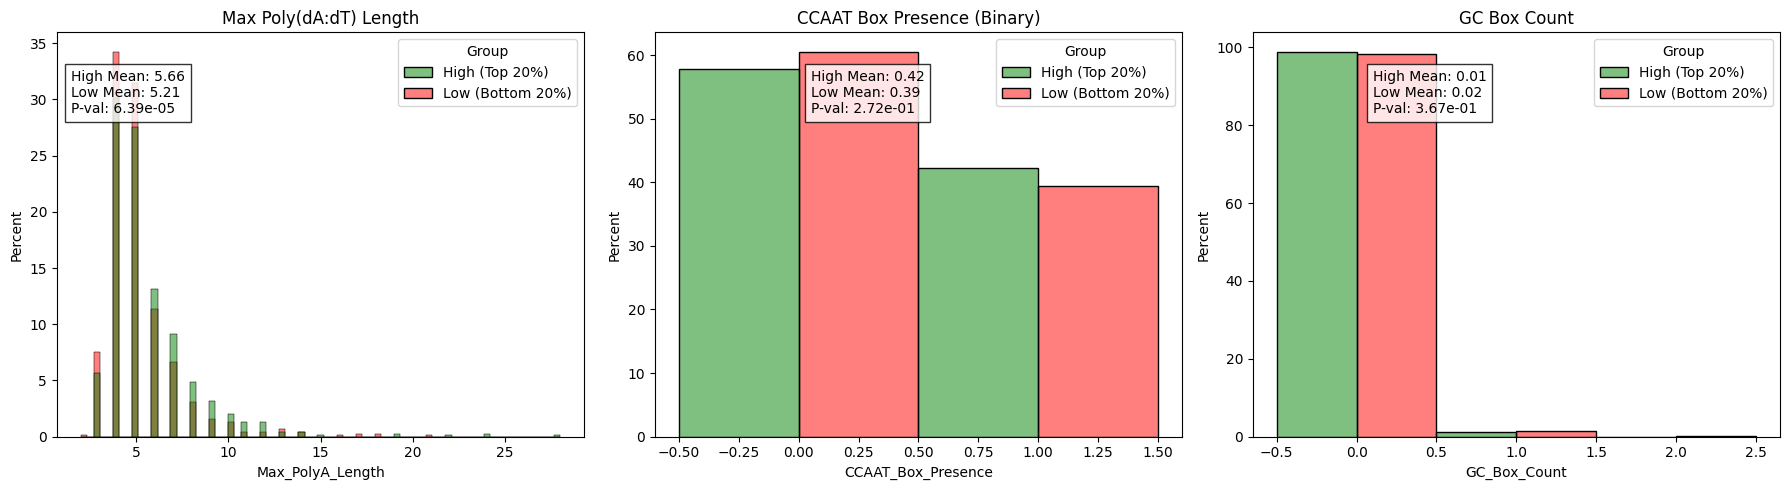


--- סיכום מסקנות ---
- פיצ'ר Max_PolyA_Length: מובהק. ערך גבוה יותר בקבוצה החזקה.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import os

# ==========================================
# 1. פונקציה לניתוח האזור הפרוקסימלי
# ==========================================

def analyze_proximal_region(row):
    full_seq = row['promoter']
    
    # הגדרת האזור הפרוקסימלי (-300 עד -100 מהסוף)
    # נניח שהרצף מסתיים ב-0 (לפני ה-ATG)
    start_pos = -300
    end_pos = -100
    
    # בדיקת תקינות אורך הרצף
    if len(full_seq) < abs(start_pos):
        # אם הרצף קצר מדי, ניקח את מה שיש עד ה-100 האחרונים
        if len(full_seq) > abs(end_pos):
             prox_seq = full_seq[:end_pos] # עד ה-100 האחרונים
        else:
             prox_seq = "" # רצף קצר מדי לניתוח זה
    else:
        prox_seq = full_seq[start_pos:end_pos]
        
    # --- 1. Max PolyA/T Length (Nucleosome Depletion) ---
    # מוצא רצפים רציפים של A או של T
    poly_matches = re.findall(r'A+|T+', prox_seq)
    if poly_matches:
        max_poly_len = max(len(m) for m in poly_matches)
    else:
        max_poly_len = 0
        
    # --- 2. CCAAT Box Presence (HAP Complex) ---
    # בודקים נוכחות של CCAAT או המשלים ATTGG
    has_ccaat = 1 if ('CCAAT' in prox_seq or 'ATTGG' in prox_seq) else 0
    
    # --- 3. GC Box Count (Sp1) ---
    # ספירת GGGCGG
    gc_box_count = prox_seq.count('GGGCGG')
    
    return pd.Series({
        'Max_PolyA_Length': max_poly_len,
        'CCAAT_Box_Presence': has_ccaat,
        'GC_Box_Count': gc_box_count
    })

# ==========================================
# 2. הרצה ראשית וניהול קבצים
# ==========================================

def run_proximal_analysis(csv_path):
    # חילוץ שם הקובץ המקורי ללא הסיומת
    base_filename = os.path.splitext(os.path.basename(csv_path))[0]
    output_filename = f"proximal_analysis_{base_filename}.csv"
    
    print(f"--- מעבד את הקובץ: {csv_path} ---")
    try:
        df = pd.read_csv(csv_path)
        # התאמת עמודות
        if 'promoter' not in df.columns:
             df.columns = ['promoter', 'mrna_level'] + list(df.columns[2:])
    except Exception as e:
        print(f"שגיאה בטעינת הקובץ: {e}")
        return None

    # חישוב הפיצ'רים
    print("מחלץ פיצ'רים פרוקסימליים (-300 עד -100)...")
    prox_features = df.apply(analyze_proximal_region, axis=1)
    
    # חיבור לנתונים המקוריים
    final_df = df.join(prox_features)
    
    # חישוב אחוזונים לסטטיסטיקה
    if 'expression_percentile' not in final_df.columns:
        final_df['expression_percentile'] = final_df['mrna_level'].rank(pct=True) * 100
    
    # שמירה עם השם הדינמי
    final_df.to_csv(output_filename, index=False)
    print(f"✅ נתונים נשמרו לקובץ: {output_filename}")
    
    # הפקת גרפים
    plot_proximal_stats(final_df)
    
    return final_df

# ==========================================
# 3. ויזואליזציה (80/20)
# ==========================================

def plot_proximal_stats(df):
    print("\n=== השוואה: Top 20% vs Bottom 20% (Proximal Region) ===")
    
    high_group = df[df['expression_percentile'] >= 80].copy()
    low_group = df[df['expression_percentile'] <= 20].copy()
    
    # איזון (Downsampling)
    min_size = min(len(high_group), len(low_group))
    high_bal = high_group.sample(n=min_size, random_state=42)
    low_bal = low_group.sample(n=min_size, random_state=42)
    
    high_bal['Group'] = 'High (Top 20%)'
    low_bal['Group'] = 'Low (Bottom 20%)'
    combined = pd.concat([high_bal, low_bal])
    
    features = [
        ('Max_PolyA_Length', 'Max Poly(dA:dT) Length'),
        ('CCAAT_Box_Presence', 'CCAAT Box Presence (Binary)'),
        ('GC_Box_Count', 'GC Box Count')
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    conclusions = []

    for i, (col, title) in enumerate(features):
        ax = axes[i]
        
        # היסטוגרמה
        # עבור משתנים בדידים (כמו CCAAT שהוא 0/1 או GC שהוא ספירה נמוכה),
        # discrete=True נותן תצוגה יפה יותר
        is_discrete = col in ['CCAAT_Box_Presence', 'GC_Box_Count']
        
        sns.histplot(data=combined, x=col, hue='Group', 
                     stat="percent", common_norm=False, multiple="dodge" if is_discrete else "layer",
                     palette={'High (Top 20%)': 'green', 'Low (Bottom 20%)': 'red'}, 
                     ax=ax, alpha=0.5, discrete=is_discrete)
        
        ax.set_title(title)
        
        # סטטיסטיקה
        mean_high = high_bal[col].mean()
        mean_low = low_bal[col].mean()
        
        # בחירת מבחן סטטיסטי
        # עבור משתנים בינאריים (CCAAT) עדיף Chi-Square, אבל Mann-Whitney יעבוד גם כן כקירוב
        stat, p_val = stats.mannwhitneyu(high_bal[col], low_bal[col])
        
        # הצגת נתונים
        stats_text = (f"High Mean: {mean_high:.2f}\n"
                      f"Low Mean: {mean_low:.2f}\n"
                      f"P-val: {p_val:.2e}")
        
        y_lim = ax.get_ylim()[1]
        x_lim = ax.get_xlim()[1] if not is_discrete else max(combined[col].max(), 1)
        
        ax.text(x_lim*0.05, y_lim*0.80, stats_text, 
                bbox=dict(facecolor='white', alpha=0.8))

        # מסקנות אוטומטיות
        if p_val < 0.05:
            direction = "גבוה" if mean_high > mean_low else "נמוך"
            conclusions.append(f"פיצ'ר {col}: מובהק. ערך {direction} יותר בקבוצה החזקה.")
    
    plt.tight_layout()
    plt.show()
    
    print("\n--- סיכום מסקנות ---")
    for c in conclusions:
        print(f"- {c}")

# ==========================================
# הפעלה לדוגמה
# ==========================================
df_prox = run_proximal_analysis('train1.csv')

--- מעבד את הקובץ: train2.csv ---
מחלץ פיצ'רים פרוקסימליים (-300 עד -100)...
✅ נתונים נשמרו לקובץ: proximal_analysis_train2.csv

=== השוואה: Top 20% vs Bottom 20% (Proximal Region) ===


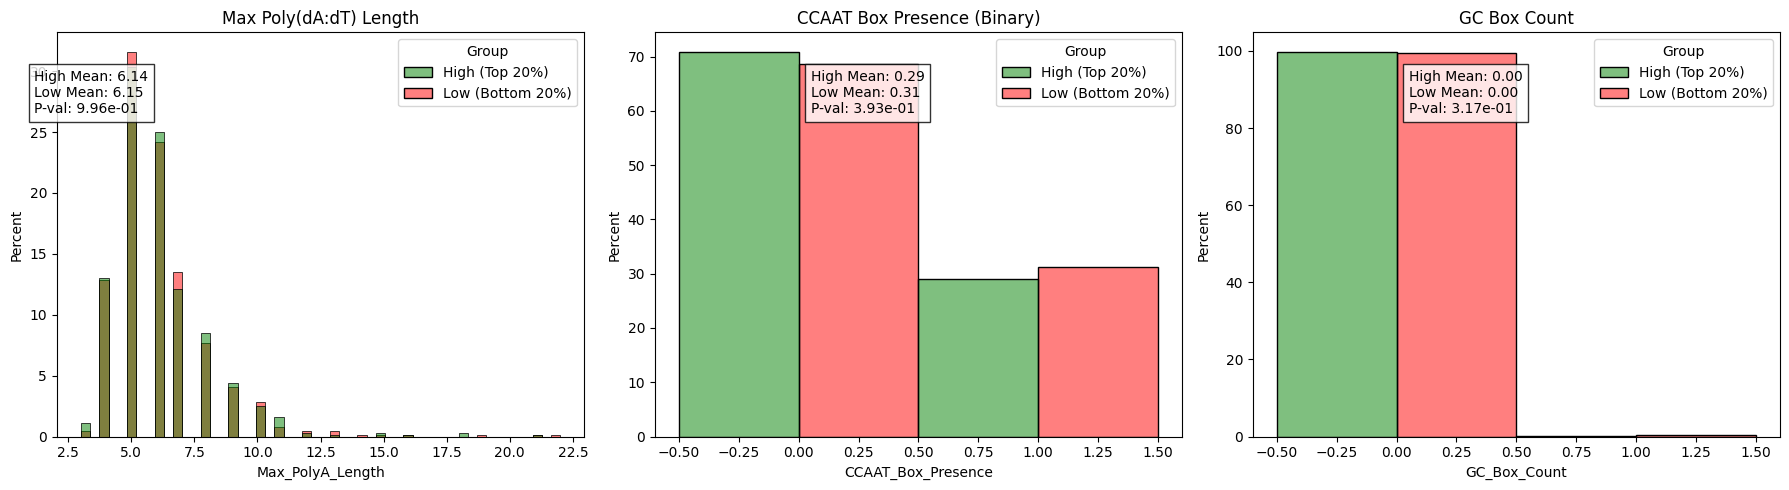


--- סיכום מסקנות ---


In [3]:
df_prox = run_proximal_analysis('train2.csv')